# Soiaporn model

Trying to recreate the model presented in Soiaporn, K. et al., 2012. Multilevel Bayesian framework for modeling the production, propagation and detection of ultra-high energy cosmic rays. arXiv.org, astro-ph.HE(3), pp.1249–1285.

In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from matplotlib import pyplot as plt
import numpy as np
import pystan
from fancy import *

In [2]:
# read in relevant data
source_file = '../data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Sources

The UHECR are generated in a homogeneous poisson process, with the expected number of UHECR per unit time for each source governed by a standard candle luminosity function. In this way, the weight of each source is defined by its distance from the Earth. 

Each UHECR has an associated arrival time and integer label.

In summary:
* $F \sim Poisson(F_k)$
* $\lambda \sim Categorical(\frac{F_k}{\sum_{j=0}^{N_A} F_j})$ 

In [3]:
# set source parameters
F_T = 1000 # total flux
f = 0.7 # associated fraction
F_A = f * F_T # source flux

In [4]:
# calculate source weights based on AGN distances
# distances to AGN
D = data.source['AGN'].distance

# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D, f):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    return w

w = get_weights(D, f)

In [5]:
# find actual number of events to simulate
# expected F_k for sources
F_k_exp = []
for w_k in w:
    F_k_exp.append(int(round(w_k * F_A)))
print ('f * F_T:', f * F_T)

# source F_k
F = []
for f_k_exp in F_k_exp:
    F.append(np.random.poisson(f_k_exp))
print ('Total source flux:', sum(F))
    
# background F_0
F_0_exp = F_T - sum(F_k_exp)
F_0 = np.random.poisson(F_0_exp)
print ('Total background flux:', F_0)

f * F_T: 700.0
Total source flux: 721
Total background flux: 291


In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Make a wapper class to store output with useful coordinates and label
class Direction():
    """
    Input the unit vector vMF samples and 
    store x, y, and z and galactic coordinates 
    of direction in Mpc.
    
    :param omega_k: unit vector
    :param norm: unit vector = vector / norm
    """
    
    def __init__(self, omega_k, norm, label):
        self.unit_vector = omega_k 
        self.norm = norm
        self.x = np.transpose(omega_k)[0] * self.norm
        self.y = np.transpose(omega_k)[1] * self.norm
        self.z = np.transpose(omega_k)[2] * self.norm
        self.d = SkyCoord(self.x, self.y, self.z, 
                          unit = 'mpc', 
                          representation_type = 'cartesian', 
                          frame = 'galactic')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg
        self.label = label

## Propagation

Each UHECR undergoes deflection once it has been produced by a source. The deflection is modelled using the von Mises - Fisher distribution and is independent for each UHECR.

In [7]:
# set the propagation parameter
kappa = 100

In [10]:
# simulate the isotropic background, k = 0
def sample_unit_sphere(n_samples):
    # unit sphere
    r = 1

    u = np.random.uniform(0, 1, n_samples)
    v = np.random.uniform(0, 1, n_samples)
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)

    # convert to cartesian and norm
    x = r * np.cos(theta) * np.sin(phi) 
    y = r * np.sin(theta) * np.sin(phi) 
    z = r * np.cos(phi) 
    return np.transpose([x, y, z])

background = Direction(sample_unit_sphere(F_0), norm = 1, label = 0)

In [11]:
sys.path.append('../')
from vMF import *

# sample from the vMF distribution 
# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
varpi = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
varpi = np.transpose(varpi)
        
# simulate events
omega = []
mus = []
for i in range(N_A):
    N = F[i]
    # normalise to unit sphere for sampling, then revert
    norm = np.linalg.norm(varpi[i])
    mu = varpi[i] / norm
    mus.append(Direction(mu, norm, 100))
    omega_k = (sample_vMF(mu, kappa, N))
    omega.append(Direction(omega_k, norm, i + 1))

## Detection 

Following the deflection due to propagation, there is a further "deflection". The UHECR are detected indirectly and the quoted arrival direction has an associated uncertainty that is due to the reconstruction of the air shower.

In [12]:
# set the detection parameter
kappa_c = 1000

In [36]:
# simulate one eventsfor each true arrival direction
detected = []
for o in omega:
    d_i = []
    for uv in o.unit_vector:
        d_i.append(sample_vMF(uv, kappa_c, 1)[0])
    detected.append(Direction(d_i, o.norm, o.label))

## Visualise the simulation

Plot the simulated UHECR on a skymap with the host catalog and color the UHECR according to their associated labels.

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


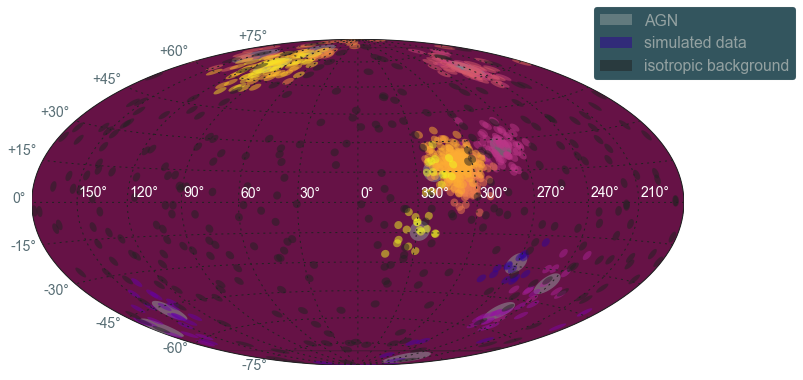

In [37]:
# plot the results on a skymap
# sources
fig, skymap = data.show()
# simulated data
# plot each label as a spearate colour
cmap = plt.cm.get_cmap('plasma', N_A) 
add_label = True
for d in detected:
    for lon, lat, label in np.nditer([d.lons, d.lats, d.label]):
        if add_label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = cmap(label), alpha = 0.5, 
                          label = 'simulated data')
            add_label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = cmap(label), alpha = 0.5)
# simulated background
add_label = True
for lon, lat in np.nditer([background.lons, background.lats]): 
    if add_label:
        skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                      label = 'isotropic background')
        add_label = False
    else:
       skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)  
   
plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))

## Modelling in Stan

